/tmp/ipykernel_32532/1312846932.py:106: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpja1x6_tm/hfo6qalp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpja1x6_tm/v38dfr5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/agsa/Documents/Projects/Personal_projects/Forecasting_ML_microservice/train/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73848', 'data', 'file=/tmp/tmpja1x6_tm/hfo6qalp.json', 'init=/tmp/tmpja1x6_tm/v38dfr5f.json', 'output', 'file=/tmp/tmpja1x6_tm/prophet_model3zwrwn5c/prophet_model-20250404184245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done proces

🏃 View run big-gnat-172 at: http://127.0.0.1:5000/#/experiments/250329204548197133/runs/a5d5e00b4d0f4367b9f950309518af2a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/250329204548197133


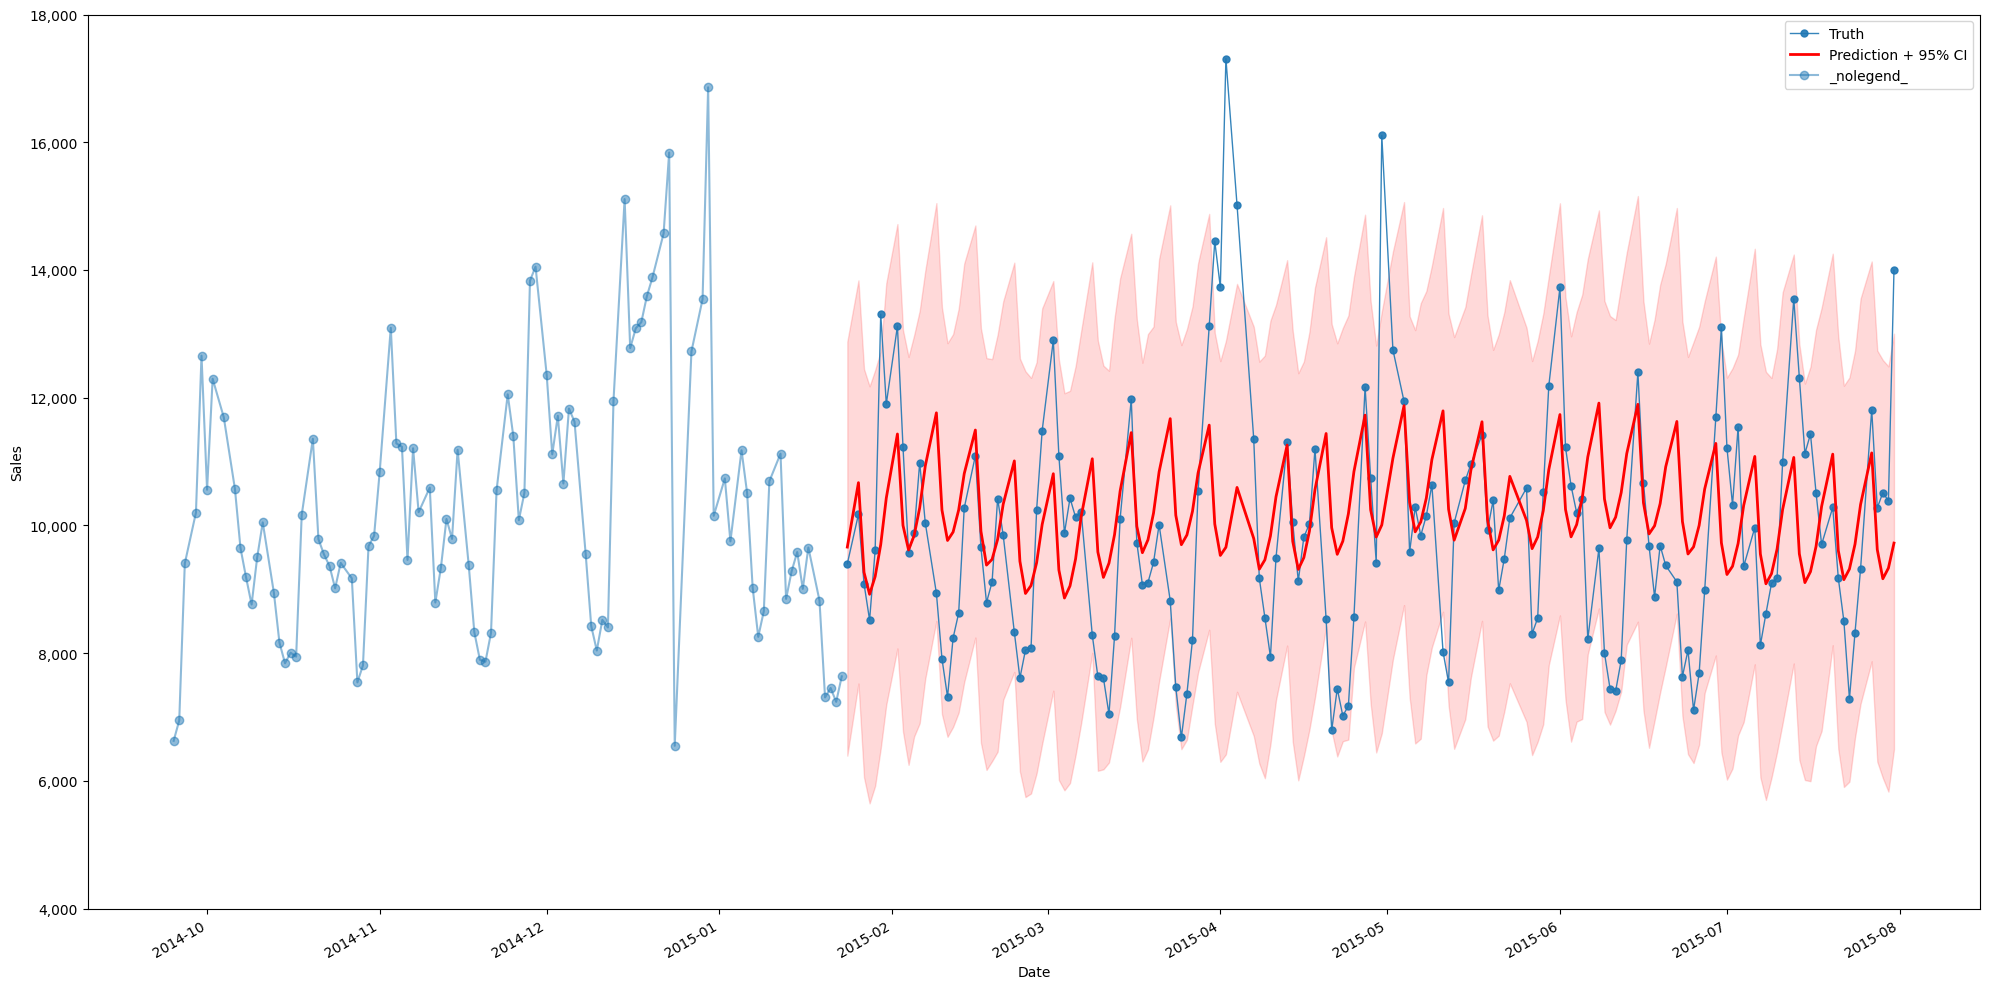

In [1]:
import os
import logging
import kaggle
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from pathlib import Path

import mlflow

# config kaggle json and download the dataset.
def download_kaggle_dataset(kaggle_dataset: str = "pratyushakar/rossmann-store-sales") -> None:
    kaggle.api.dataset_download_files(kaggle_dataset, path='./data', unzip=True, quiet=False)

def prep_store_data(df: pd.DataFrame, store_id: int = 4, store_open: int = 1) -> pd.DataFrame:
    df["Date"] = pd.to_datetime(df["Date"])
    df.rename(columns = {"Date": "ds", "Sales": "y"}, inplace=True)
    df_store = df[
        (df["Store"] == store_id ) &\
        (df["Open"] == store_open)
    ].reset_index(drop=True)
    return df_store.sort_values("ds", ascending=True)

def train_predict(df: pd.DataFrame, train_fraction: float, seasonality: dict) -> tuple[pd.DataFrame, pd.DataFrame, int]:
    train_index = int(train_fraction*df.shape[0])
    df_train = df.copy().iloc[0:train_index]
    df_test = df.copy().iloc[train_index:]

    model = Prophet(
        yearly_seasonality = seasonality["yearly"],
        weekly_seasonality = seasonality["weekly"],
        daily_seasonality = seasonality["daily"],
        interval_width = 0.95
    )

    model.fit(df_train)
    predicted = model.predict(df_test)
    
    return predicted, df_train, df_test, train_index

def plot_forecast(df_train: pd.DataFrame, df_test: pd.DataFrame, predicted: pd.DataFrame, train_index: int, results_path: str) -> None:
    fig, ax = plt.subplots(figsize=(20, 10))
    df_test.plot(
        x="ds",
        y="y",
        ax=ax,
        label="Truth",
        linewidth=1,
        markersize=5,
        color="tab:blue",
        alpha=0.9,
        marker="o"
    )
    predicted.plot(
        x="ds",
        y="yhat",
        ax=ax,
        label="Prediction + 95% CI",
        linewidth=2,
        markersize=5,
        color="red"
    )
    ax.fill_between(
        x=predicted["ds"],
        y1=predicted["yhat_upper"],
        y2=predicted["yhat_lower"],
        alpha=0.15,
        color="red"
    )
    df_train.iloc[train_index-100:].plot(
        x="ds",
        y="y",
        ax=ax,
        color='tab:blue',
        label="_nolegend_",
        alpha=0.5,
        marker="o",
    )
    
    yticks = plt.gca().get_yticks()
    ax.set_yticks(yticks)
    ax.set_yticklabels(["{:,.0f}".format(x) for x in yticks])
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, "store_data_forecast.png"))

def main():

    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.set_experiment("prophet_models_04042025")
    mlflow.autolog()

    results_path = "./results/"
    Path(results_path).mkdir(exist_ok=True)
    data_path = "./data/"
    train_file = "train.csv"
    file_path = os.path.join(data_path, train_file)

    if os.path.exists(file_path):
        logging.info("Dataset already exists!")
    else:
        logging.info("Dataset not found, Downloading ...")
        download_kaggle_dataset()

    df = pd.read_csv(file_path)
    df = prep_store_data(df)

    seasonality = {
        "yearly": True,
        "weekly": True,
        "daily": False,
    }

    with mlflow.start_run():
        predicted, df_train, df_test, train_index = train_predict(df = df, train_fraction = 0.8, seasonality = seasonality)

    plot_forecast(df_train, df_test, predicted, train_index, results_path)


if __name__ == "__main__":
    main()
